In [6]:
# 内容来源于：：https://zhuanlan.zhihu.com/p/72237160
# 特征工程与模型调优：https://zhuanlan.zhihu.com/p/38155122
# kaggel数据集：https://www.kaggle.com/c/titanic/overview
# https://www.cnblogs.com/bonelee/p/8632866.html?tdsourcetag=s_pcqq_aiomsg
# 特征权重： https://machinelearningmastery.com/calculate-feature-importance-with-python/

# 0.导入相关包
import numpy as np 
import pandas as pd 
import seaborn as sns
from sklearn import preprocessing
import matplotlib.pyplot as plt 


In [7]:
# 1.预览数据
plt.rc("font", size=14)   # 设置字体大小
sns.set(style="white")    #设置seaborn画图的背景为白色
sns.set(style="whitegrid", color_codes=True)

# 将数据读入 DataFrame
df = pd.read_csv("train.csv")
print('数据集包含的数据个数 {}.'.format(df.shape[0]))

数据集包含的数据个数 891.


In [8]:
# 预览数据，显示前5行数据
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [9]:
# 2.查看数据集中各个特征缺失的情况
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [11]:
# 2.1年龄缺失百分比
print('"Age" 缺失的百分比  %.2f%%' %((df['Age'].isnull().sum()/df.shape[0])*100))

"Age" 缺失的百分比  19.87%


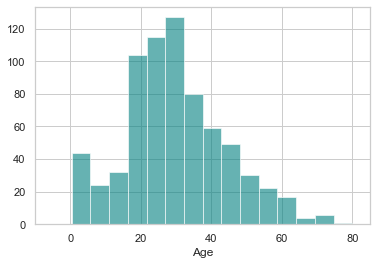

In [13]:
# 年龄缺失分布
ax = df["Age"].hist(bins=15, color='teal', alpha=0.6)
ax.set(xlabel='Age')
plt.xlim(-10,85)
plt.show()

In [18]:
# 由于“年龄”的偏度不为0, 使用均值替代缺失值不是最佳选择, 这里可以选择使用中间值替代缺失值注：在概率论和统计学中，
# 偏度衡量实数随机变量概率分布的不对称性。偏度的值可以为正，可以为负或者甚至是无法定义。在数量上，偏度为负（负偏态）
# 就意味着在概率密度函数左侧的尾部比右侧的长，绝大多数的值（不一定包括中位数在内）位于平均值的右侧。偏度为正（正偏态）
# 就意味着在概率密度函数右侧的尾部比左侧的长，绝大多数的值（不一定包括中位数）位于平均值的左侧。偏度为零就表示数值相对
# 均匀地分布在平均值的两侧，但不一定意味着其为对称分布。

In [20]:
# 年龄的均值
print('The mean of "Age" is %.2f' %(df["Age"].mean(skipna=True)))
# 年龄的中间值
print('The median of "Age" is %.2f' %(df["Age"].median(skipna=True)))


The mean of "Age" is 29.70
The median of "Age" is 28.00


In [29]:
#2.2 仓位缺失百分比
print("仓位缺失百分比  %.2f%% " %  (df['Cabin'].isnull().sum()/df.shape[0]*100))
#约 77% 的乘客的仓位都是缺失的, 最佳的选择是不使用这个特征的值.

仓位缺失百分比  77.10% 


In [30]:
# 2.4登船地点的缺失率
print('"Embarked" 缺失的百分比 %.2f%%' %((df['Embarked'].isnull().sum()/df.shape[0])*100))
#只有 0.23% 的乘客的登船地点数据缺失, 可以使用众数替代缺失的值.

"Embarked" 缺失的百分比 0.22%


按照登船地点分组 (C = Cherbourg, Q = Queenstown, S = Southampton):
S    644
C    168
Q     77
Name: Embarked, dtype: int64


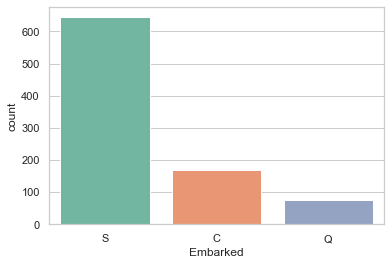

In [35]:
print('按照登船地点分组 (C = Cherbourg, Q = Queenstown, S = Southampton):')
print(df['Embarked'].value_counts())
sns.countplot(x='Embarked', data=df, palette='Set2')
plt.show()

In [36]:
print('乘客登船地点的众数为 %s.' %df['Embarked'].value_counts().idxmax())

乘客登船地点的众数为 S.


In [37]:
#由于大多数人是在南安普顿(Southhampton)登船, 可以使用“S”替代缺失的数据值
# 2.5. 根据缺失数据情况调整数据
# 基于以上分析, 我们进行如下调整:
# 如果一条数据的 "Age" 缺失, 使用年龄的中位数 28 替代.
# 如果一条数据的 "Embarked" 缺失, 使用登船地点的众数 “S” 替代.
# 由于太多乘客的 “Cabin” 数据缺失, 从所有数据中丢弃这个特征的值.

In [39]:
data = df.copy()
data["Age"].fillna(df["Age"].median(skipna=True), inplace=True)
data["Embarked"].fillna(df['Embarked'].value_counts().idxmax(), inplace=True)
data.drop('Cabin', axis=1, inplace=True)

# 确认数据是否还包含缺失数据
data.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

In [40]:
# 如果数据中持续有缺失值，需要进行填补
#显示缺失值所在的乘客信息
data[data.isnull().values==True]
#显示缺失值所在的乘客信息发现，某一位乘客缺失值太多，直接删除该乘客所有信息。
# data.drop([1309],inplace=True)
# data[data.isnull().values==True]
#还有一人缺失票价信息，用票价众数代替

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked


In [47]:
data.iloc[139,:] # 选择特定行和列，https://pandas.pydata.org/pandas-docs/stable/getting_started/intro_tutorials/03_subset_data.html

PassengerId                   140
Survived                        0
Pclass                          1
Name           Giglio, Mr. Victor
Sex                          male
Age                            24
SibSp                           0
Parch                           0
Ticket                   PC 17593
Fare                         79.2
Embarked                        C
Name: 139, dtype: object

D:\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\hist.py:316: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(values, bins=bins, **kwds)
D:\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\hist.py:316: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(values, bins=bins, **kwds)


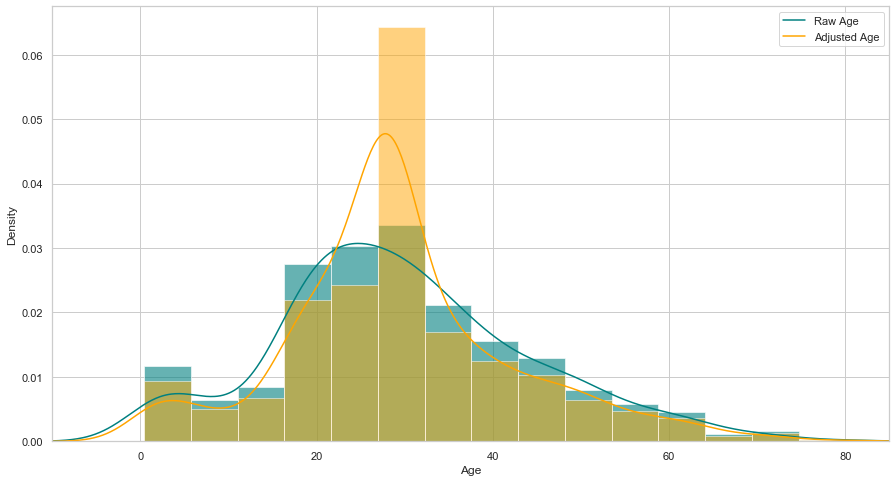

In [48]:
# 查看年龄在调整前后的分布
plt.figure(figsize=(15,8))
ax = df["Age"].hist(bins=15, normed=True, stacked=True, color='teal', alpha=0.6)
df["Age"].plot(kind='density', color='teal')
ax = data["Age"].hist(bins=15, normed=True, stacked=True, color='orange', alpha=0.5)
data["Age"].plot(kind='density', color='orange')
ax.legend(['Raw Age', 'Adjusted Age'])
ax.set(xlabel='Age')
plt.xlim(-10,85)
plt.show()

In [49]:
# 2.451. 其它特征的处理 解决多重共线性问题
# 数据中的两个特征 “sibsp” (一同登船的兄弟姐妹或者配偶数量)与“parch”(一同登船的父母或子女数量)都是代表是否有同伴同行.
# 为了预防这两个变量可能的多重共线性, 我们可以将这两个变量转为一个变量 “TravelAlone” (是否独自一人成行)注: 
    
# 多重共线性(multicollinearity)是指多变量线性回归中，变量之间由于存在高度相关关系而使回归估计不准确。比如虚拟变量陷阱
# （英语：Dummy variable trap）即有可能触发多重共线性问题。
## 创建一个新的变量'TravelAlone'记录是否独自成行, 丢弃“sibsp” 
# (一同登船的兄弟姐妹或者配偶数量)与“parch”(一同登船的父母或子女数量)


In [52]:
data['TravelAlone']=np.where((data["SibSp"]+data["Parch"])>0, 0, 1)
data.drop('SibSp', axis=1, inplace=True)
data.drop('Parch', axis=1, inplace=True)

In [55]:
# 对类别变量(categorical variables)使用独热编码(One-Hot Encoding), 将字符串类别转换为数值
# 对 Embarked","Sex"进行独热编码, 丢弃 'name', 'ticket'
final =pd.get_dummies(data, columns=["Embarked","Sex"])
final.drop('Name', axis=1, inplace=True)
final.drop('Ticket', axis=1, inplace=True)
final.head()

,PassengerId,Survived,Pclass,Age,Fare,TravelAlone,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male
0,1,0,3,22.0,7.2500,0,0,0,1,0,1
1,2,1,1,38.0,71.2833,0,1,0,0,1,0
2,3,1,3,26.0,7.9250,1,0,0,1,1,0
3,4,1,1,35.0,53.1000,0,0,0,1,1,0
4,5,0,3,35.0,8.0500,1,0,0,1,0,1


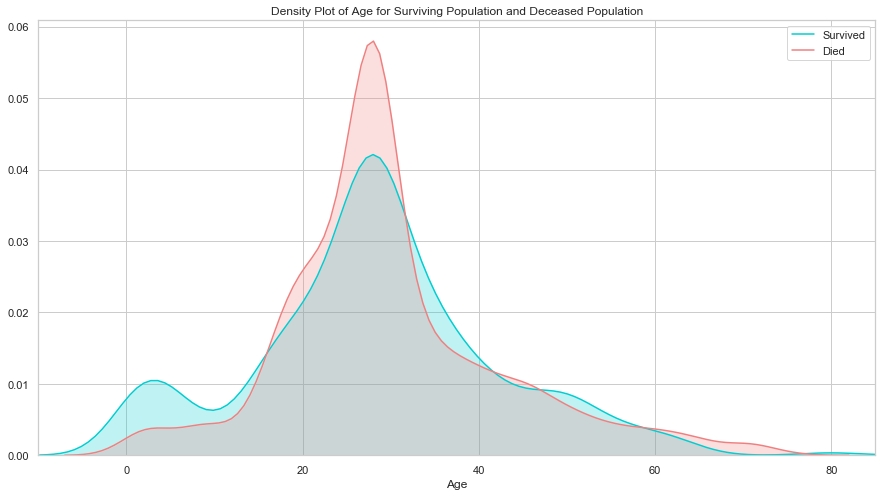

In [57]:
#3. 数据分析
#3.1. 年龄
plt.figure(figsize=(15,8))
ax = sns.kdeplot(final["Age"][final.Survived == 1], color="darkturquoise", shade=True)
sns.kdeplot(final["Age"][final.Survived == 0], color="lightcoral", shade=True)
plt.legend(['Survived', 'Died'])
plt.title('Density Plot of Age for Surviving Population and Deceased Population')
ax.set(xlabel='Age')
plt.xlim(-10,85)
plt.show()

In [ ]:
# 生还与遇难群体的分布相似, 唯一大的区别是生还群体中用一部分低年龄的乘客. 说明当时的人预先保留了孩子的生还机会.

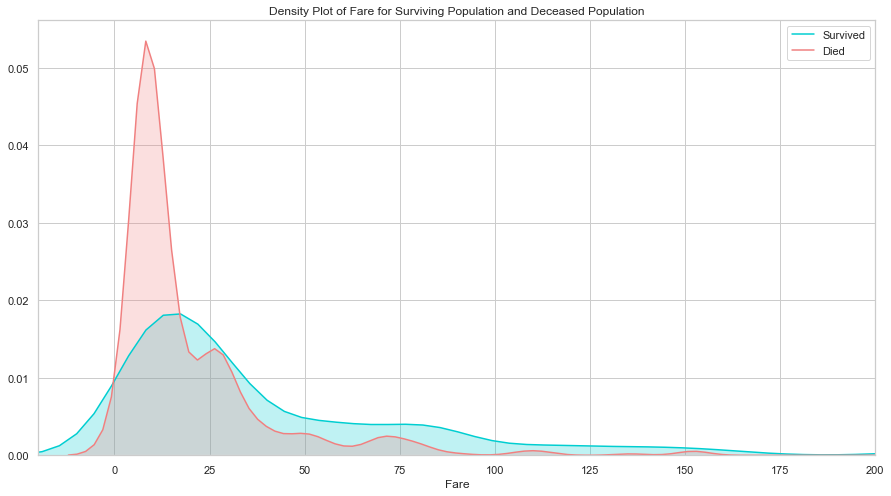

In [59]:
# 3.2. 票价
plt.figure(figsize=(15,8))
ax = sns.kdeplot(final["Fare"][final.Survived == 1], color="darkturquoise", shade=True)
sns.kdeplot(final["Fare"][final.Survived == 0], color="lightcoral", shade=True)
plt.legend(['Survived', 'Died'])
plt.title('Density Plot of Fare for Surviving Population and Deceased Population')
ax.set(xlabel='Fare')
plt.xlim(-20,200)
plt.show()

In [ ]:
# 生还与遇难群体的票价分布差异比较大, 说明这个特征对预测乘客是否生还非常重要. 票价和仓位相关, 也许是仓位影响了逃生的效果, 我们接下来看仓位的分析.

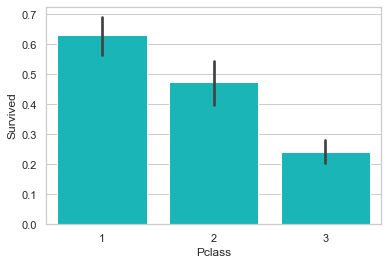

In [60]:
#3.3. 仓位
sns.barplot('Pclass', 'Survived', data=df, color="darkturquoise")
plt.show()

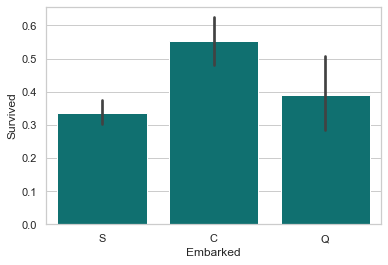

In [61]:
# 3.4. 登船地点
sns.barplot('Embarked', 'Survived', data=df, color="teal")
plt.show()

In [ ]:
#从法国 Cherbourge 登录的乘客生还率最高


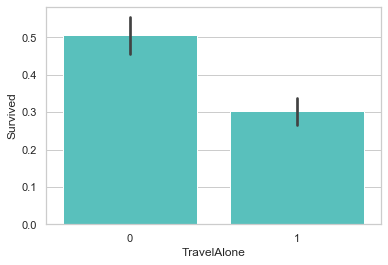

In [62]:
# 3.5. 是否独自成行
sns.barplot('TravelAlone', 'Survived', data=final, color="mediumturquoise")
plt.show()

In [ ]:
# 独自成行的乘客生还率比较低. 当时的年代, 大多数独自成行的乘客为男性居多.

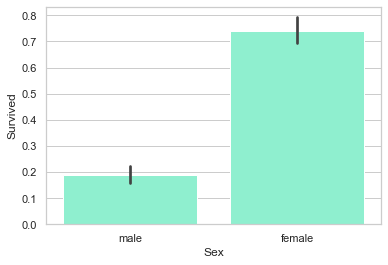

In [63]:
# 3.6. 性别
sns.barplot('Sex', 'Survived', data=df, color="aquamarine")
plt.show()

In [64]:
# 4. 使用Logistic Regression做预测

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 使用如下特征做预测
cols = ["Age","Fare","TravelAlone","Pclass","Embarked_C","Embarked_S","Sex_male"] 

# 创建 X (特征) 和 y (类别标签)
X = final[cols]
y = final['Survived']

# 将 X 和 y 分为两个部分
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

# 检测 logistic regression 模型的性能
# TODO 添加代码:
# 1.训练模型,  
# 2.根据模型, 以 X_test 为输入, 生成变量 y_pred

logreg = LogisticRegression()
logreg.fit(X_train, y_train.values.reshape(-1))
y_pred = logreg.predict(X_test)
# print('在测试数据集上面的预测准确率: {:.2f}'.format(logreg.score(X_test, y_test)))


print('Train/Test split results:')
print("准确率为 %2.3f" % accuracy_score(y_test, y_pred))

Train/Test split results:
准确率为 0.765


D:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [65]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.86      0.80       100
           1       0.78      0.65      0.71        79

    accuracy                           0.77       179
   macro avg       0.77      0.75      0.76       179
weighted avg       0.77      0.77      0.76       179



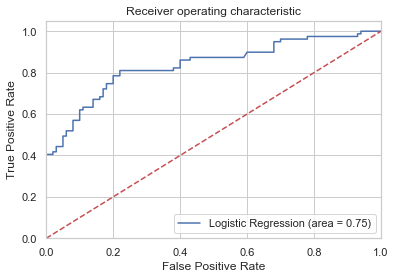

In [66]:
#ROC曲线
#曲线下方所围面积越大，分类效果越好
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [72]:
# 计算变量权重，https://machinelearningmastery.com/calculate-feature-importance-with-python/

importance = logreg.coef_[0]
# print(importance)
for i,v in enumerate(importance):
     print('Feature: %0d, Score: %.5f' % (i,v))

[-0.02631317  0.00255133  0.04776082 -0.86739052  0.37694478 -0.05459046
 -2.44262944]
Feature: 0, Score: -0.02631
Feature: 1, Score: 0.00255
Feature: 2, Score: 0.04776
Feature: 3, Score: -0.86739
Feature: 4, Score: 0.37694
Feature: 5, Score: -0.05459
Feature: 6, Score: -2.44263


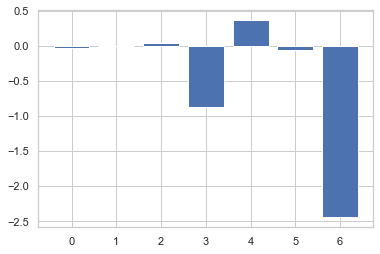

In [73]:
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [79]:
# https://stackoverflow.com/questions/56071964/how-to-create-a-pandas-dataframe-from-two-lists-with-each-value-of-first-list-ha
# df = pd.DataFrame([(i, s) for i in cols for s in importance ], columns=['cols', 'importance'])

feature_importance = pd.DataFrame([cols,importance]).T

print(feature_importance)

             0           1
0          Age  -0.0263132
1         Fare  0.00255133
2  TravelAlone   0.0477608
3       Pclass   -0.867391
4   Embarked_C    0.376945
5   Embarked_S  -0.0545905
6     Sex_male    -2.44263
